<div style="text-align: center">
    <h1 style="font-size: 54px;"><strong>Deep learning for EEG-based human emotion recognition:</strong></h1>
</div>
<!-- <div style="text-align: center">
    <h3 h1 style="font-size: 40px;"><strong>4-class CNN classifier based on valence-arousal quadrants (DEAP Dataset)</strong></h3>
</div> -->

# **Table of contents**

# **1. Project overview**

# **2. Imports**

Let's first import all the necessary packages and libraries.


In [224]:
import gdown
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.signal import spectrogram
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# **3. Loading and previewing EEG data**

## **3.1. Data exploration**

In [3]:
# file_id = '1IoR5kEBG86NHZcfYVGMCOdqV8S7MdKnu'
# gdown.download(f'https://drive.google.com/uc?id={file_id}', 'data_preprocessed_python/s01.dat', quiet=False)


We load EEG data for subject 1 from the DEAP dataset using Python’s pickle module. The `'rb'` flag opens the file in binary read mode, and `'latin1'` encoding ensures compatibility with the original format.

In [4]:
with open('data_preprocessed_python/s01.dat', 'rb') as file:    
    subject_data = pickle.load(file, encoding='latin1')

In [5]:
type(subject_data)

dict

In [6]:
print(subject_data.keys())

dict_keys(['labels', 'data'])


In [7]:
subject_eeg_data = subject_data['data']
subject_labels = subject_data['labels']

print(subject_eeg_data.shape)
print(subject_labels.shape)

(40, 40, 8064)
(40, 4)


The dataset is a Python dictionary containing two keys: `labels` and `data`.

`subject_data['data']` is an array of shape **40 x 40 x 8064** representing EEG and EOG data from 40 signal channels (32 EEG + 8 EOG). Each channel was sampled at 128 Hz over 60-second trials, resulting in 8064 time samples per trial. A total of 40 trials were recorded for this subject while watching 40 different videos.

`subject_data['labels']` is an array of shape **40 x 4**, where each row corresponds to a trial (one video) and contains subjective emotional ratings given by the participant. The four dimensions are:

- **valence** (*column 0*), 
- **arousal** (*column 1*), 
- **dominance** (*column 2*), and 
- **liking** (*column 3*). 

Emotional ratings were given on a **continuous scale from 1 to 9**, where higher values represent more positive valence, higher arousal, dominance, and liking.

*(See the samples of the data below)*

In [8]:
print(subject_eeg_data[0])

[[ 9.48231681e-01  1.65333533e+00  3.01372577e+00 ... -2.82648937e+00
  -4.47722969e+00 -3.67692812e+00]
 [ 1.24706590e-01  1.39008270e+00  1.83509881e+00 ... -2.98702069e+00
  -6.28780884e+00 -4.47429041e+00]
 [-2.21651099e+00  2.29201682e+00  2.74636923e+00 ... -2.63707760e+00
  -7.40651010e+00 -6.75590441e+00]
 ...
 [ 2.30779684e+02  6.96716323e+02  1.19512165e+03 ...  1.01080949e+03
   1.28312149e+03  1.51996480e+03]
 [-1.54180981e+03 -1.61798052e+03 -1.69268642e+03 ... -1.57842691e+04
  -1.57823160e+04 -1.57808512e+04]
 [ 6.39054310e-03  6.39054310e-03  6.39054310e-03 ... -9.76081241e-02
  -9.76081241e-02 -9.76081241e-02]]


In [9]:
df_labels = pd.DataFrame(
    subject_labels, 
    columns=['valence', 'arousal', 'dominance', 'liking']
)

df_labels.head(10)

,valence,arousal,dominance,liking
0,1.29,1.40,6.90,7.83
1,0.90,1.69,7.28,8.47
2,0.42,1.46,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
5,8.27,3.92,7.00,8.03
6,7.44,3.73,7.08,7.04
7,7.32,2.55,6.32,5.87
8,4.04,3.29,3.62,5.99
9,1.99,4.86,2.04,7.09


## **3.2. Data visualization**

First, we will look at the raw signal recorded during the first movie presentation. The plot below shows the record of the **first 5 seconds (640 samples)**.

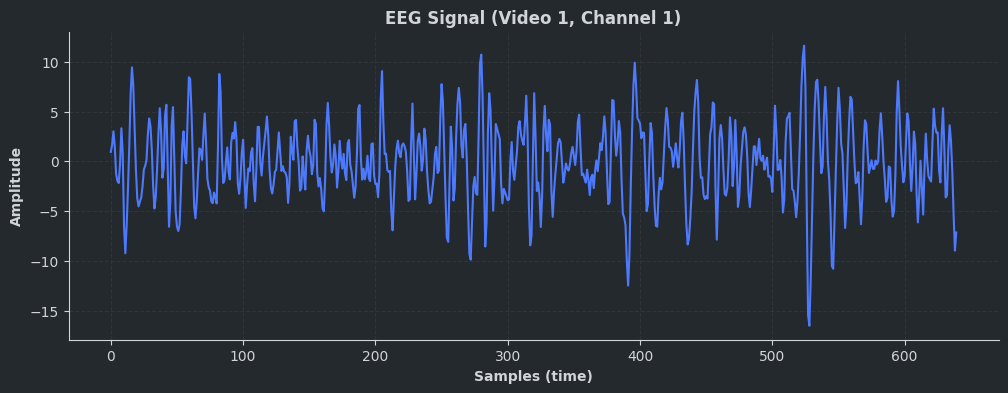

In [10]:
video_index = 0
channel_index = 0
sampling_frequency = 128

sample_signal = subject_eeg_data[video_index, channel_index, 0:sampling_frequency*5]

plt.figure(figsize=(12, 4))

ax = plt.gca()
ax.set_facecolor('#24292e')
plt.gcf().patch.set_facecolor('#24292e')

plt.plot(sample_signal, color='#4D79FD') 
plt.title(f'EEG Signal (Video {video_index + 1}, Channel {channel_index + 1})', color='#d1d5da', fontweight='bold')
plt.xlabel('Samples (time)', color='#d1d5da', fontweight='bold')
plt.ylabel('Amplitude', color='#d1d5da', fontweight='bold')

ax.tick_params(colors='#d1d5da')
ax.spines['bottom'].set_color('#d1d5da')
ax.spines['left'].set_color('#d1d5da')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(True, linestyle='--', color='#313439')

plt.show()


The EEG signal shown above — already preprocessed in the source data to remove common artifacts such as eye blinks — reflects clean neural activity patterns suitable for further transformation into **frequency-domain features**. These features will later serve as input for a **convolutional neural network (CNN)** model in our emotion classification task.

To better understand the temporal dynamics of these frequency components, using `SciPy` library we compute a **spectrogram** of the signal recorded during the first movie presentation from the first channel. Spectrograms allow us to visualize **how the power of various frequency bands evolves over time**, which is particularly important in EEG-based emotion recognition — since distinct emotional states are often linked to specific oscillatory patterns in the brain (e.g., **Alpha (8-13 Hz)** suppression during heightened arousal, or increased **Theta (4-8 Hz)** activity during calmness or introspection).

*Note:*
*Due to the use of sliding windows with overlap in spectrogram computation* `(nperseg=128, noverlap=64)`*, the resulting time axis starts slightly after 0 seconds and ends before 5 seconds. This ensures that each time window contains a complete set of samples needed for the Fourier transform.*


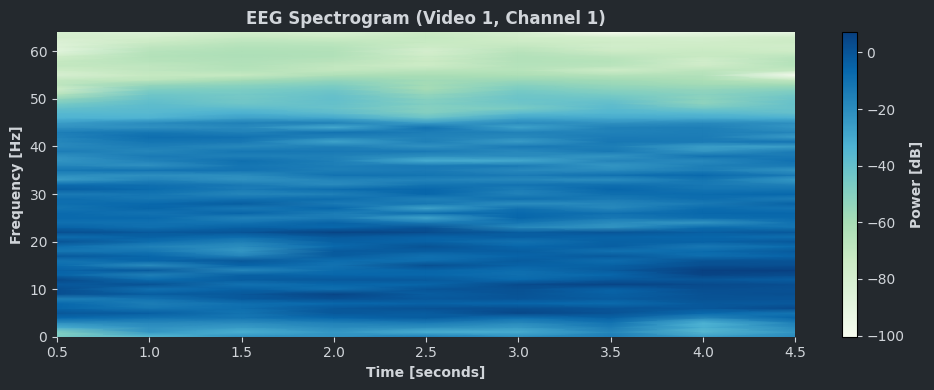

In [11]:
frequencies, times, spec_power = spectrogram(
    sample_signal, 
    fs=sampling_frequency, 
    nperseg=128, 
    noverlap=64
)

plt.figure(figsize=(10, 4))

ax = plt.gca()
ax.set_facecolor('#24292e')
plt.gcf().patch.set_facecolor('#24292e')

pcm = plt.pcolormesh(
    times, 
    frequencies, 
    10 * np.log10(spec_power), 
    shading='gouraud', 
    cmap='GnBu'
)

plt.title(f'EEG Spectrogram (Video {video_index + 1}, Channel {channel_index + 1})', color='#d1d5da', fontweight='bold')
plt.xlabel('Time [seconds]', color='#d1d5da', fontweight='bold')
plt.ylabel('Frequency [Hz]', color='#d1d5da', fontweight='bold')

ax.tick_params(colors='#d1d5da')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(False)

cbar = plt.colorbar(pcm)
cbar.ax.yaxis.set_tick_params(color='#d1d5da')
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='#d1d5da')
cbar.set_label('Power [dB]', color='#d1d5da', fontweight='bold')

plt.tight_layout()
plt.show()


# **4. Neural network modeling**

## **4.1. Aggregating EEG data from all participants**

In [12]:
data_path = 'data_preprocessed_python'
all_eeg_data = []
all_labels = []

for i in range(1, 33):
    file_name = f's{i:02}.dat'
    file_path = os.path.join(data_path, file_name)

    with open(file_path, 'rb') as f:
        subject_data = pickle.load(f, encoding='latin1')
        all_eeg_data.append(subject_data['data'])
        all_labels.append(subject_data['labels'])

eeg_data_all = np.concatenate(all_eeg_data, axis=0)
labels_all = np.concatenate(all_labels, axis=0)

print(eeg_data_all.shape)
print(labels_all.shape)


(1280, 40, 8064)
(1280, 4)


## **4.2. Generating binary labels for classification**

In [206]:
valence_labels = labels_all[:, 0] 
# binary_liking = (valence_labels > 6).astype(int)

mask = (valence_labels < 4) | (valence_labels > 6)

valence_filtered = valence_labels[mask]
eeg_filtered = eeg_data_all[mask]
binary_liking = (valence_filtered > 6).astype(int)

print(np.unique(binary_liking, return_counts=True))

(array([0, 1]), array([795, 167], dtype=int64))


## **4.3. Generating EEG spectrograms for input features**

In [231]:
# def compute_log_spectrogram(signal, fs=sampling_frequency, nperseg=128, noverlap=64):
#     f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
#     return np.log10(Sxx + 1e-10)

# all_spectrograms = []

# for trial in eeg_filtered:
#     trial_specs = []
#     for ch in range(32):
#         signal = trial[ch, :10240]
#         signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-10)
#         spec = compute_log_spectrogram(signal)
#         trial_specs.append(spec)
#     all_spectrograms.append(trial_specs)

# X = np.array(all_spectrograms)
# y = binary_liking        

# print(X.shape)
# print(y.shape)


from scipy.signal import welch

def bandpower(signal, fs, band):
    f, Pxx = welch(signal, fs=fs)
    band_mask = (f >= band[0]) & (f <= band[1])
    return np.sum(Pxx[band_mask])

bands = {
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

X_features = []

for trial in eeg_filtered:
    features = []
    for ch in range(32):
        signal = trial[ch, :640]
        signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-10)
        for band in bands.values():
            bp = bandpower(signal, fs=128, band=band)
            features.append(bp)
    X_features.append(features)

X = np.array(X_features)
y = binary_liking

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (962, 128)
y shape: (962,)


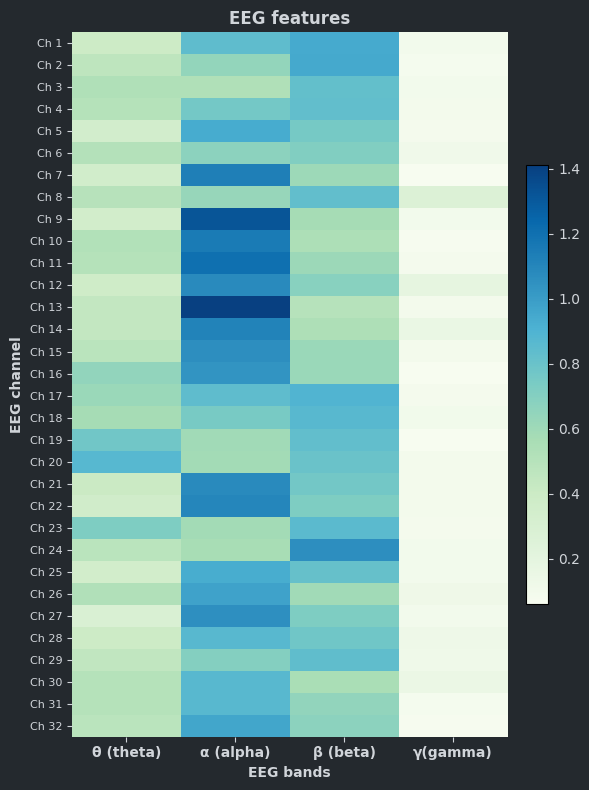

In [236]:
import matplotlib.pyplot as plt
import numpy as np

# Ustawienia stylu
background_color = '#24292e'
text_color = '#d1d5da'
grid_color = '#313439'
cmap = 'GnBu'  # można też: 'viridis', 'inferno', 'magma'

# Przykład: pierwszy trial
example = X[0].reshape(32, 4)  # 32 kanały, 4 pasma

# Wykres
fig, ax = plt.subplots(figsize=(6, 8))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

im = ax.imshow(example, aspect='auto', cmap=cmap)

# Etykiety osi
ax.set_title("EEG features", color=text_color, fontweight='bold')
ax.set_xlabel("EEG bands", color=text_color, fontweight='bold')
ax.set_ylabel("EEG channel", color=text_color, fontweight='bold')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['θ (theta)', 'α (alpha)', 'β (beta)', 'γ(gamma)'], color=text_color, fontweight='bold')
ax.set_yticks(np.arange(32))
ax.set_yticklabels([f'Ch {i+1}' for i in range(32)], color=text_color, fontsize=8)

# Siatka i ramka
ax.tick_params(colors=text_color)
for spine in ax.spines.values():
    spine.set_visible(False)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_tick_params(color=text_color)
plt.setp(cbar.ax.yaxis.get_ticklabels(), color=text_color)

plt.tight_layout()
plt.show()


## **4.4. Dataset partitioning for model training and evaluation**

In [217]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [225]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(128,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


c:\Users\Huawei\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [226]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5410 - loss: 0.7256 - val_accuracy: 0.8238 - val_loss: 0.5132
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8282 - loss: 0.4983 - val_accuracy: 0.8238 - val_loss: 0.5015
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8287 - loss: 0.4769 - val_accuracy: 0.8238 - val_loss: 0.4901
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8346 - loss: 0.4732 - val_accuracy: 0.8238 - val_loss: 0.4856
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8202 - loss: 0.5013 - val_accuracy: 0.8238 - val_loss: 0.4875
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8156 - loss: 0.5047 - val_accuracy: 0.8238 - val_loss: 0.4837
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8289 - loss: 0.4818 - val_accuracy: 0.8238 - val_loss: 0.4818
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8586 - loss: 0.4338 - val_accuracy: 0.8238 - val_los

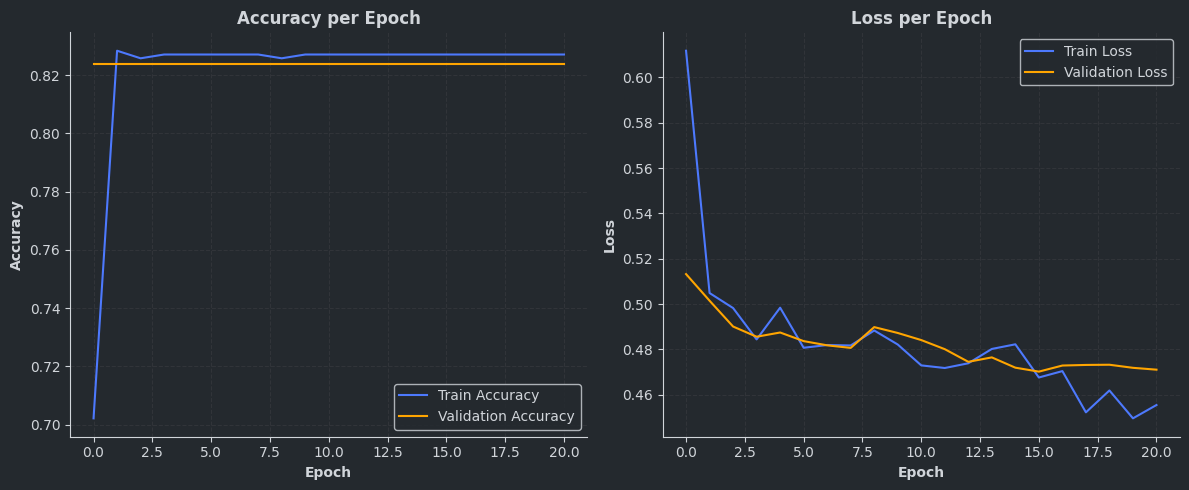

In [227]:
import matplotlib.pyplot as plt

# Ustawienia wspólne
background_color = '#24292e'
line_color = '#4D79FD'
text_color = '#d1d5da'
grid_color = '#313439'

plt.figure(figsize=(12, 5))

# Accuracy
ax1 = plt.subplot(1, 2, 1)
ax1.set_facecolor(background_color)
plt.gcf().patch.set_facecolor(background_color)

ax1.plot(history.history['accuracy'], label='Train Accuracy', color=line_color)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax1.set_title('Accuracy per Epoch', color=text_color, fontweight='bold')
ax1.set_xlabel('Epoch', color=text_color, fontweight='bold')
ax1.set_ylabel('Accuracy', color=text_color, fontweight='bold')
ax1.legend(facecolor=background_color, edgecolor=text_color, labelcolor=text_color)
ax1.tick_params(colors=text_color)
ax1.spines['bottom'].set_color(text_color)
ax1.spines['left'].set_color(text_color)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(True, linestyle='--', color=grid_color)

# Loss
ax2 = plt.subplot(1, 2, 2)
ax2.set_facecolor(background_color)

ax2.plot(history.history['loss'], label='Train Loss', color=line_color)
ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax2.set_title('Loss per Epoch', color=text_color, fontweight='bold')
ax2.set_xlabel('Epoch', color=text_color, fontweight='bold')
ax2.set_ylabel('Loss', color=text_color, fontweight='bold')
ax2.legend(facecolor=background_color, edgecolor=text_color, labelcolor=text_color)
ax2.tick_params(colors=text_color)
ax2.spines['bottom'].set_color(text_color)
ax2.spines['left'].set_color(text_color)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, linestyle='--', color=grid_color)

plt.tight_layout()
plt.show()


In [228]:
test_loss, test_accuracy, = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8427 - loss: 0.4321 
Test Accuracy: 0.8238
Test Loss: 0.4702


In [229]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Prawdopodobieństwa z modelu Keras
y_pred_probs = model.predict(X_test)

# Zamiana na klasy 0 lub 1 (np. przy thresholdzie 0.5)
y_pred = (y_pred_probs > 0.5).astype(int)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_probs))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.8238341968911918
AUC: 0.5486496485386607


In [230]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      1.00      0.90       159
           1       0.00      0.00      0.00        34

    accuracy                           0.82       193
   macro avg       0.41      0.50      0.45       193
weighted avg       0.68      0.82      0.74       193



c:\Users\Huawei\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Huawei\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Huawei\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
